In [7]:
from scipy.optimize import least_squares, minimize
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets
from scipy.stats import norm

In [8]:
class CustomARIMA:
  def __init__(self, p, d, q):
    self.p, self.d, self.q = p, d, q  # AR, differencing, MA order
    
  def _arima_residuals(self, params, y):
    c, ar_params, ma_params = params[0], params[1:self.p+1], params[self.p+1:]
    
    # Initialize residuals with first d values of y
    residuals = y[:self.d].copy()
    
    # Apply differencing
    for i in range(self.d, len(y)):
      y_diff = y[i] - c
      for j in range(1, self.p+1):
        y_diff -= ar_params[j-1] * y[i-j]
      for k in range(1, min(i, self.q)+1):
        y_diff -= ma_params[k-1] * residuals[i-k]
      residuals = np.append(residuals, y_diff)

    # Compute negative log likelihood
    nll = -np.sum(np.log(norm.pdf(residuals[self.d:])))
    return nll
    
  def fit(self, y):
    # Initialize parameters
    init_params = np.random.rand(1 + self.p + self.q)
    
    # Define bounds for parameters
    bounds = [(None, None)] + [(None, None)] * (self.p + self.q)
    
    # Minimize negative log likelihood
    result = minimize(self._arima_residuals, init_params, args=(y,), bounds=bounds)
    
    # Save parameters
    self.params = result.x
    
    return self.params

  def predict(self, y):
    c = self.params[0]
    ar_params = self.params[1:self.p+1]
    ma_params = self.params[self.p+1:]

    # Initialize predictions with first d values of y
    predictions = y[:self.d].copy()

    # Apply differencing
    for i in range(self.d, len(y)):
      y_pred = c
      for j in range(1, self.p+1):
          y_pred += ar_params[j-1] * y[i-j]
      for k in range(1, min(i, self.q)+1):
          y_pred += ma_params[k-1] * predictions[i-k]
      predictions = np.append(predictions, y_pred)

    return predictions[self.d:]

In [15]:
# Generate example data
np.random.seed(0)
n = 100
ar_params = [0.3, -0.1]
ma_params = [0.1]
y = np.random.normal(size=n)
for i in range(2, n):
  y[i] = ar_params[0]*y[i-1] + ar_params[1]*y[i-2] + ma_params[0]*y[i-1] + np.random.normal()

# Fit ARIMA model
arima_model = CustomARIMA(p=2, d=0, q=1)
arima_model.fit(y)

# Make predictions
predictions = arima_model.predict(y)

C:\Users\chris\AppData\Local\Temp\ipykernel_12560\406044306.py:21: RuntimeWarning: divide by zero encountered in log
  nll = -np.sum(np.log(norm.pdf(residuals[self.d:])))
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


### Periodical Sinusoidal with Non-Gaussian Noise

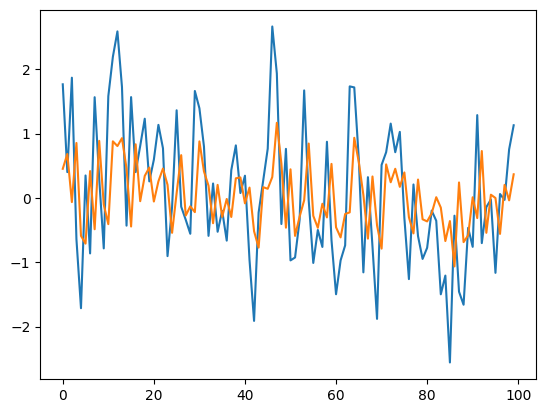

In [16]:
plt.plot(y)
plt.plot(predictions)